In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

import joblib


In [13]:
#1.Load dataset and inspect features and labels distribution.
import pandas as pd

# Load dataset
df = pd.read_csv("breast-cancer.csv")

# View first 5 rows
print(df.head())

# Separate Features and Target
X = df.drop('diagnosis', axis=1)   # Features
y = df['diagnosis']                # Target

print("Feature shape:", X.shape)
print("Label shape:", y.shape)

# Check class distribution
print("Class Distribution:")
print(y.value_counts())

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

print("Encoded Class Distribution:")
print(pd.Series(y).value_counts())


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [14]:
#2.Apply StandardScaler to normalize feature values.
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
#3.Split data into train-test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
#4.Train baseline SVM with linear kernel and check performance.
svm_linear = SVC(kernel='linear')

svm_linear.fit(X_train_scaled, y_train)

y_pred_linear = svm_linear.predict(X_test_scaled)

print("Linear Kernel Accuracy:", accuracy_score(y_test, y_pred_linear))


Linear Kernel Accuracy: 0.9649122807017544


In [17]:
#5.Train SVM with RBF kernel and compare accuracy.
svm_rbf = SVC(kernel='rbf')

svm_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = svm_rbf.predict(X_test_scaled)

print("RBF Kernel Accuracy:", accuracy_score(y_test, y_pred_rbf))


RBF Kernel Accuracy: 0.9649122807017544


In [18]:
#6.Use GridSearchCV to tune C and gamma values.
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.01, 0.1, 1],
    'svm__kernel': ['rbf']
}
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Best Parameters: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best CV Accuracy: 0.9736263736263737


In [19]:
#7.Evaluate best model using confusion matrix and classification report.
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Confusion Matrix:
 [[72  0]
 [ 2 40]]
Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



AUC Score: 0.996031746031746


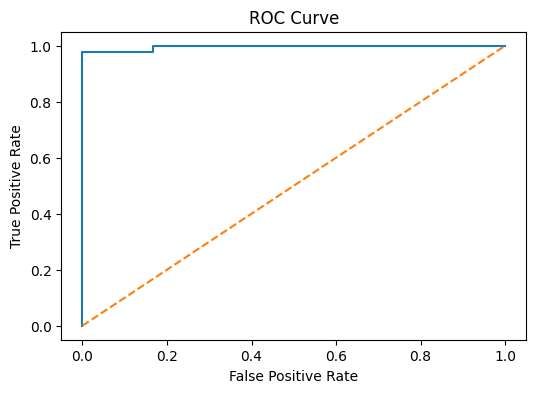

In [20]:
#8.Plot ROC curve and calculate AUC score.
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

print("AUC Score:", auc_score)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


In [21]:
#9.Save tuned model pipeline (scaler + svm) for reuse.
joblib.dump(best_model, "breast_cancer_svm_model.pkl")

print("Model Saved Successfully!")


Model Saved Successfully!
